# XGBoost运行示例

以下示例仅用于说明XGBoost的工作流程，目前仅支持单机测试。

初始化mpc设备

In [ ]:
from common import MPCInitializer
import secretflow as sf
mpc_init = MPCInitializer()
company, partner, coordinator = mpc_init.company, mpc_init.partner, mpc_init.coordinator
spu = mpc_init.spu

# 设置设备
devices = {
    'spu': spu,
    'company': company,
    'partner': partner,
    'coordinator': coordinator,
}

heu_devices = (mpc_init.company_heu, mpc_init.partner_heu)

/home/lvx_vitae/anaconda3/envs/sf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-17 15:59:30,469	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-09-17 15:59:30,694	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
/home/lvx_vitae/anaconda3/envs/sf/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/home/lvx_vitae/anaconda3/envs/sf/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompa

(SPURuntime pid=454839) 2025-09-17 15:59:36.649 [warning] [openssl_factory.cc:OpensslDrbg:83] Yacl has been configured to use Yacl's entropy source, but unable to find one. Fallback to use openssl's default entropy srouce
(SPURuntime pid=454839) 2025-09-17 15:59:36.650 [warning] [openssl_factory.cc:OpensslDrbg:83] Yacl has been configured to use Yacl's entropy source, but unable to find one. Fallback to use openssl's default entropy srouce


(pyu_fn pid=454850) /home/lvx_vitae/AnonymVFL/AnonymVFL/XGBoost.py:659: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
(pyu_fn pid=454850)   buckets = np.array(buckets)


(HEUSkKeeper(heu_id=139663987472656, party=company) pid=454849) [2025-09-17 15:59:39.869] [info] [thread_pool.cc:30] Create a fixed thread pool with size 15
(HEUEvaluator(heu_id=139663957687648, party=company) pid=454848) [2025-09-17 15:59:46.584] [info] [thread_pool.cc:30] Create a fixed thread pool with size 15 [repeated 3x across cluster]


(pyu_fn pid=454850) 2025-09-17 16:05:06,420,420 INFO [xla_bridge.py:backends:863] Unable to initialize backend 'cuda': 
(pyu_fn pid=454850) 2025-09-17 16:05:06,420,420 INFO [xla_bridge.py:backends:863] Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
(pyu_fn pid=454850) 2025-09-17 16:05:06,421,421 INFO [xla_bridge.py:backends:863] Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
(pyu_fn pid=454850) 2025-09-17 16:05:06,421,421 WARNING [xla_bridge.py:_suggest_missing_backends:901] An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


(pyu_fn pid=454850) [2025-09-17 16:05:06.435] [info] [thread_pool.cc:30] Create a fixed thread pool with size 15
(pyu_fn pid=454850) [2025-09-17 16:05:06.449] [warning] [openssl_factory.cc:83] Yacl has been configured to use Yacl's entropy source, but unable to find one. Fallback to use openssl's default entropy srouce
(pyu_fn pid=454850) [2025-09-17 16:05:06.451] [warning] [openssl_factory.cc:83] Yacl has been configured to use Yacl's entropy source, but unable to find one. Fallback to use openssl's default entropy srouce
(SPURuntime(device_id=None, party=company) pid=454839) 2025-09-17 16:05:08.368 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 15


(pyu_fn pid=454842) 2025-09-17 16:05:08,614,614 INFO [xla_bridge.py:backends:863] Unable to initialize backend 'cuda': 
(pyu_fn pid=454842) 2025-09-17 16:05:08,614,614 INFO [xla_bridge.py:backends:863] Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
(pyu_fn pid=454842) 2025-09-17 16:05:08,615,615 INFO [xla_bridge.py:backends:863] Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
(pyu_fn pid=454842) 2025-09-17 16:05:08,615,615 INFO [xla_bridge.py:backends:863] Unable to initialize backend 'interpreter': jaxlib.xla_extension.Client: no constructor defined!
(pyu_fn pid=454842) 2025-09-17 16:05:08,615,615 WARNING [xla_bridge.py:_suggest_missing_backends:901] An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


(pyu_fn pid=454842) [2025-09-17 16:05:08.730] [warning] [openssl_factory.cc:83] Yacl has been configured to use Yacl's entropy source, but unable to find one. Fallback to use openssl's default entropy srouce
(pyu_fn pid=454842) [2025-09-17 16:05:08.731] [warning] [openssl_factory.cc:83] Yacl has been configured to use Yacl's entropy source, but unable to find one. Fallback to use openssl's default entropy srouce


(pyu_fn pid=454845) 2025-09-17 16:07:00,279,279 INFO [xla_bridge.py:backends:863] Unable to initialize backend 'cuda': 
(pyu_fn pid=454845) 2025-09-17 16:07:00,280,280 INFO [xla_bridge.py:backends:863] Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
(pyu_fn pid=454845) 2025-09-17 16:07:00,281,281 INFO [xla_bridge.py:backends:863] Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
(pyu_fn pid=454845) 2025-09-17 16:07:00,281,281 INFO [xla_bridge.py:backends:863] Unable to initialize backend 'interpreter': jaxlib.xla_extension.Client: no constructor defined!
(pyu_fn pid=454845) 2025-09-17 16:07:00,281,281 WARNING [xla_bridge.py:_suggest_missing_backends:901] An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


(SPURuntime(device_id=None, party=partner) pid=454844) 2025-09-17 16:05:08.377 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 15 [repeated 2x across cluster]
(pyu_fn pid=454845) [2025-09-17 16:07:00.290] [warning] [openssl_factory.cc:83] Yacl has been configured to use Yacl's entropy source, but unable to find one. Fallback to use openssl's default entropy srouce [repeated 2x across cluster]


(raylet) [2025-09-17 16:12:32,899 E 454722 454722] node_manager.cc:3178: 3 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: ba03d4d29b9113af7cc672d55c6040a7a4ee18a4517c008bed6bc77a, IP: 192.168.10.9) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 192.168.10.9`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(raylet) 
(raylet) [2025-09-17 16:13:32,901 E 454722 454722] node_manager.cc:3178: 1 Workers (tasks / actors) killed due to 

双方读取数据集。数据集为csv格式，应包含id列"id"和标签列"y"。id列为字符串，其他列为数值型特征。

将键值和特征分开读取。

In [2]:
import pandas as pd
import os
import numpy as np
project_dir = os.path.dirname(os.path.abspath(''))

def read_dataset(path: str):
    data = pd.read_csv(path)
    keys = data['id'].astype(str).tolist()
    private_features = data.drop(columns=['id']).to_numpy(dtype=np.float32)
    header = data.columns.tolist()
    return keys, private_features, header
company_keys, company_features, company_header = company(read_dataset,num_returns=3)(os.path.join(project_dir, 'Datasets/data/data/breast_hetero_host.csv'))
partner_keys, partner_features, partner_header = partner(read_dataset,num_returns=3)(os.path.join(project_dir, 'Datasets/data/data/breast_hetero_guest.csv'))
company_header = sf.reveal(company_header)
partner_header = sf.reveal(partner_header)
# active_party一般为标签的持有者
if 'y' in company_header:
    devices['active_party'] = company
elif 'y' in partner_header:
    devices['active_party'] = partner
else:
    raise ValueError("标签列'y'未找到")
#输出交集的列标题
header = company_header[1:] + partner_header[1:]
#记录标签列的索引
y_col = header.index('y')

XGBoost需要在PSI开始之前预先分桶

In [3]:
from XGBoost import quantize_buckets
import numpy as np
K_quantiles = 20
Quantiles1, _, buckets_labels1 = company(quantize_buckets,num_returns=3)(company_features, k=K_quantiles)
partner_train_features = partner(lambda features: features[:,:-1])(partner_features)
Quantiles2, _, buckets_labels2 = partner(quantize_buckets,num_returns=3)(partner_train_features, k=K_quantiles) #最后一列是y无需分桶

分位点合并为联邦数组形式

In [4]:
from secretflow.data.ndarray import load
from secretflow.data import PartitionWay
FedQuantiles = load({company: Quantiles1, partner: Quantiles2}, partition_way=PartitionWay.HORIZONTAL)

将key,feature和bucket_label整合到一个元组中

In [5]:
def make_triplet(x,y,z):
    return (x,y,z)

company_data = company(make_triplet)(company_keys,company_features,buckets_labels1)
partner_data = partner(make_triplet)(partner_keys,partner_features,buckets_labels2)

执行PSI

求交后得到交集共享分片，分别由company和partner持有。原本company数据的特征在share的左侧，partner数据的特征在右侧。

In [6]:
from PSI import private_set_intersection
company_share, partner_share, bucket_labels = private_set_intersection(company_data, partner_data,heu_devices)
company_share.device(np.savetxt)('../company_share.csv',company_share, delimiter=',')
partner_share.device(np.savetxt)('../partner_share.csv',partner_share, delimiter=',')

Computing masked company cipher
Computing masked partner cipher
Computing company shares
Computing partner shares


将交集的分桶标签恢复为桶

In [7]:
from XGBoost import recover_buckets
buckets = recover_buckets(bucket_labels)

/home/lvx_vitae/AnonymVFL/AnonymVFL/XGBoost.py:673: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(buckets)


将训练集转移到对应设备

In [8]:
def split_X_y(share):
    X = np.delete(share, y_col, axis=1)
    y = share[:, y_col].reshape(-1, 1)
    return X, y

def share2spu(company_share, partner_share):
    company_share = company_share.to(spu)
    partner_share = partner_share.to(spu)
    return spu(lambda x, y : x + y)(company_share, partner_share)

X_train_company, y_train_company = company(split_X_y,num_returns=2)(company_share)
X_train_partner, y_train_partner = partner(split_X_y,num_returns=2)(partner_share)
X_train = share2spu(X_train_company, X_train_partner)
y_train = devices['active_party'](lambda x, y : x + y)(y_train_company.to(devices['active_party']), y_train_partner.to(devices['active_party']))


读取验证集

In [9]:
def read_val_dataset(path):
    data = pd.read_csv(path)
    private_features = data.iloc[:, 1:].to_numpy(dtype=np.float32)
    return private_features
X_test_company = company(read_val_dataset)(os.path.join(project_dir, 'Datasets/data/data/breast_hetero_host_test.csv'))
X_test_partner = partner(read_val_dataset)(os.path.join(project_dir, 'Datasets/data/data/breast_hetero_guest_test.csv'))
X_test_partner, y_test = partner(lambda arr : (arr[:,:-1], arr[:,-1].reshape(-1,1)),num_returns=2)(X_test_partner)
X_test = load({company: X_test_company, partner: X_test_partner})


训练

In [10]:
from XGBoost import SSXGBoost
model = SSXGBoost(devices=devices, max_depth=2, n_estimators=2, div=False)

train_accs, test_accs = model.fit(X_train, y_train, buckets, FedQuantiles,X_test, y_test)

Aggregating buckets for each feature...


100%|██████████| 60/60 [00:07<00:00,  8.34it/s]


Calculating gradient split info...


100%|██████████| 60/60 [00:24<00:00,  2.44it/s]


Selecting best split ...
Aggregating buckets for each feature...


100%|██████████| 60/60 [00:09<00:00,  6.23it/s]


Calculating gradient split info...


100%|██████████| 60/60 [00:22<00:00,  2.67it/s]


Selecting best split ...
Aggregating buckets for each feature...


100%|██████████| 60/60 [00:09<00:00,  6.20it/s]


Calculating gradient split info...


100%|██████████| 60/60 [00:22<00:00,  2.64it/s]


Selecting best split ...
==== Iteration 0 ====
Train Loss: 992.5536, Accuracy: 0.9453
Validating test dataset...
Test Loss: 329.0292, Accuracy: 0.9432
Aggregating buckets for each feature...


100%|██████████| 60/60 [00:07<00:00,  8.39it/s]


Calculating gradient split info...


100%|██████████| 60/60 [00:24<00:00,  2.41it/s]


Selecting best split ...
Aggregating buckets for each feature...


100%|██████████| 60/60 [00:10<00:00,  5.83it/s]


Calculating gradient split info...


100%|██████████| 60/60 [00:24<00:00,  2.48it/s]


Selecting best split ...
Aggregating buckets for each feature...


100%|██████████| 60/60 [00:09<00:00,  6.02it/s]


Calculating gradient split info...


100%|██████████| 60/60 [00:23<00:00,  2.58it/s]


Selecting best split ...
==== Iteration 1 ====
Train Loss: 467.3027, Accuracy: 0.9496
Validating test dataset...
Test Loss: 154.9385, Accuracy: 0.9488


绘制准确率曲线

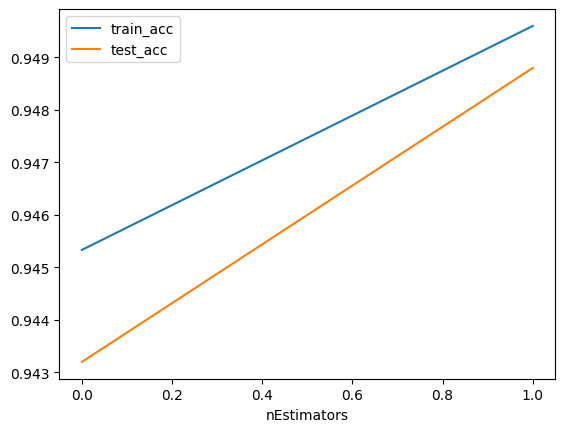

In [11]:
import matplotlib.pyplot as plt
plt.plot(train_accs,label = "train_acc")
plt.plot(test_accs,label = "test_acc")
plt.xlabel("nEstimators")
plt.legend()